In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 1000
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [18]:
data = run('NQ', breakout, output=True)

weights: 
break_5      0.213587
break_10     0.157977
break_20     0.142059
break_40     0.140042
break_80     0.152674
break_160    0.193661

adjustments:
break_5       17.673010
break_10      27.053293
break_20      37.998753
break_40      55.589357
break_80      76.007910
break_160    109.553353

multiplier:
1.4337577001279558

correlations:
            break_5  break_10  break_20  break_40  break_80  break_160
break_5    1.000000  0.695122  0.420158  0.207882  0.113365   0.051612
break_10   0.695122  1.000000  0.787785  0.482044  0.271378   0.127670
break_20   0.420158  0.787785  1.000000  0.768388  0.501159   0.263458
break_40   0.207882  0.482044  0.768388  1.000000  0.815020   0.521495
break_80   0.113365  0.271378  0.501159  0.815020  1.000000   0.779922
break_160  0.051612  0.127670  0.263458  0.521495  0.779922   1.000000

simulation start date: 2019-01-01 00:00:00


In [10]:
data.forecast.abs().mean(), data.forecast.abs().std()

(9.901297840319888, 5.904836689484041)

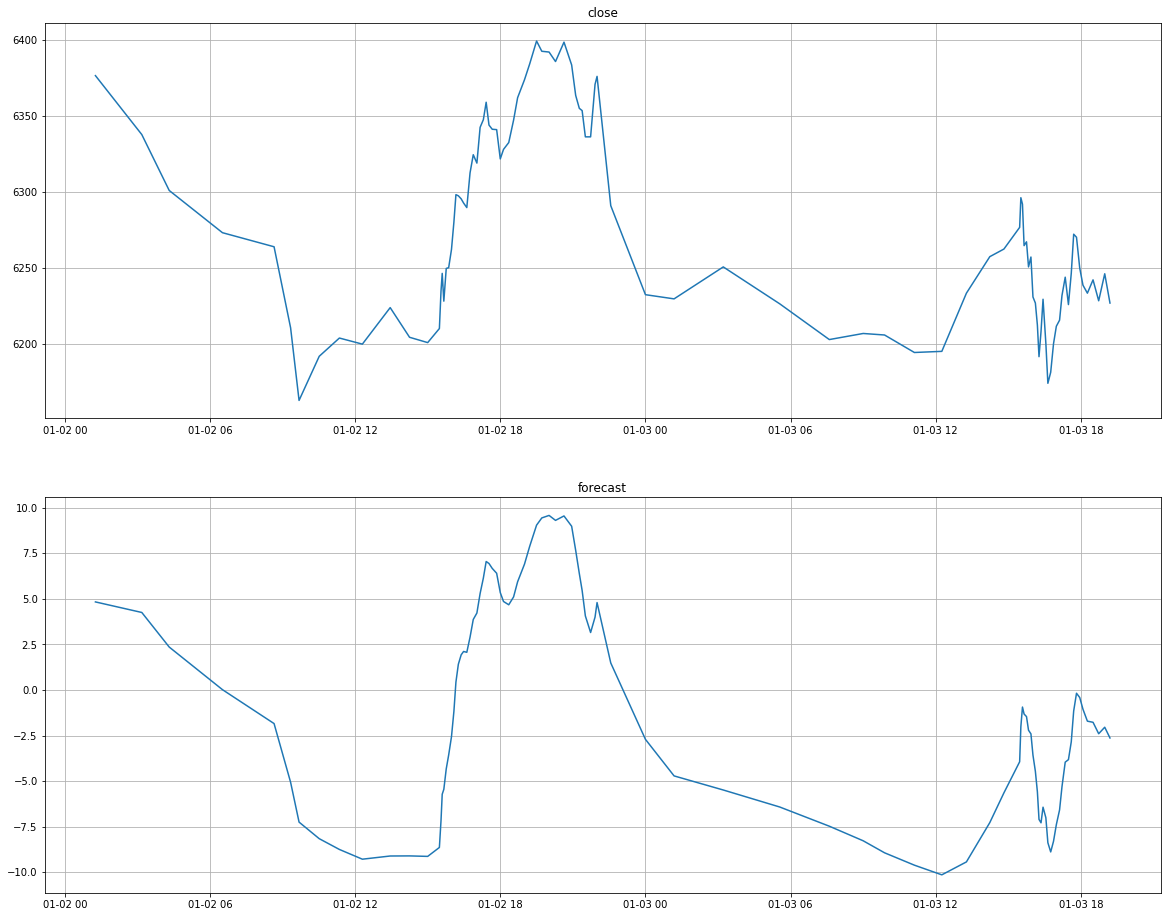

In [11]:
plot(data[['close', 'forecast']].iloc[:100])

In [12]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.278572,0.153905,0.125717,0.142552,0.0577311,0.0457333,-0.0747328,-0.0116588,-0.0375131
Cumulative returns,0.188398,0.105776,0.0867333,0.0981233,0.0402093,0.0319078,-0.0530944,-0.00820317,-0.026498
Annual volatility,0.156188,0.153834,0.145378,0.143127,0.145953,0.117311,0.092471,0.0577817,0.0480232
Sharpe ratio,1.65177,1.0071,0.886758,1.00215,0.456827,0.439182,-0.794222,-0.174445,-0.772478
Calmar ratio,2.97419,1.5874,1.27565,2.59088,0.776269,0.72198,-1.17379,-0.293324,-0.779298
Stability,0.920398,0.837845,0.737323,0.858406,0.737645,0.459642,0.203918,0.131231,0.445298
Max drawdown,-0.093663,-0.0969541,-0.0985518,-0.0550209,-0.07437,-0.0633443,-0.063668,-0.039747,-0.0481371
Omega ratio,1.31173,1.17921,1.15703,1.18379,1.08126,1.08312,0.816144,0.94879,0.759373
Sortino ratio,2.48879,1.55837,1.4179,1.66716,0.725974,0.747479,-1.31699,-0.316905,-1.51429
Skew,-0.0657066,0.346586,0.581588,0.766062,0.73381,1.29219,2.14744,3.24507,5.18012


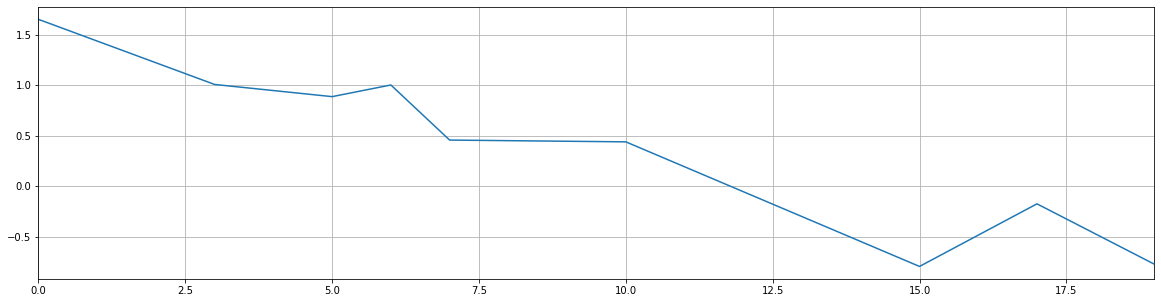

In [13]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [14]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.925232,0.832361,0.820442,0.799490,0.690315,0.443828,0.362907,0.332619
3,0.925232,1.000000,0.926158,0.888357,0.875951,0.758990,0.477515,0.389214,0.366054
5,0.832361,0.926158,1.000000,0.937691,0.922589,0.812006,0.532869,0.423057,0.385582
6,0.820442,0.888357,0.937691,1.000000,0.971261,0.841045,0.555188,0.439559,0.402700
7,0.799490,0.875951,0.922589,0.971261,1.000000,0.854087,0.575199,0.453608,0.413227
10,0.690315,0.758990,0.812006,0.841045,0.854087,1.000000,0.650754,0.521964,0.486187
15,0.443828,0.477515,0.532869,0.555188,0.575199,0.650754,1.000000,0.769371,0.659217
17,0.362907,0.389214,0.423057,0.439559,0.453608,0.521964,0.769371,1.000000,0.782669
19,0.332619,0.366054,0.385582,0.402700,0.413227,0.486187,0.659217,0.782669,1.000000


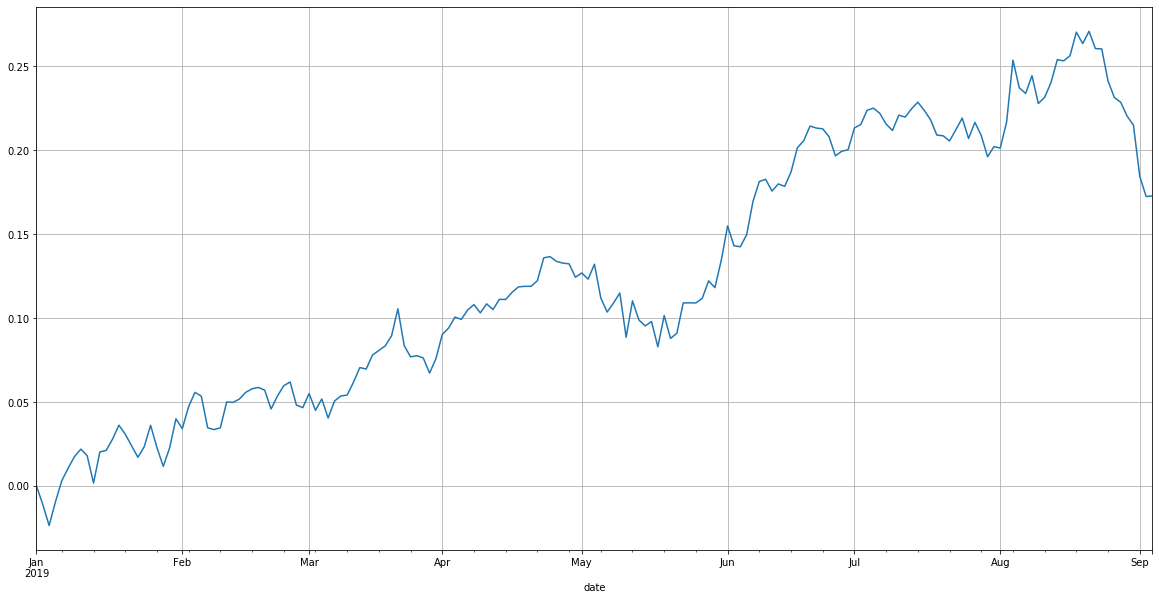

In [15]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

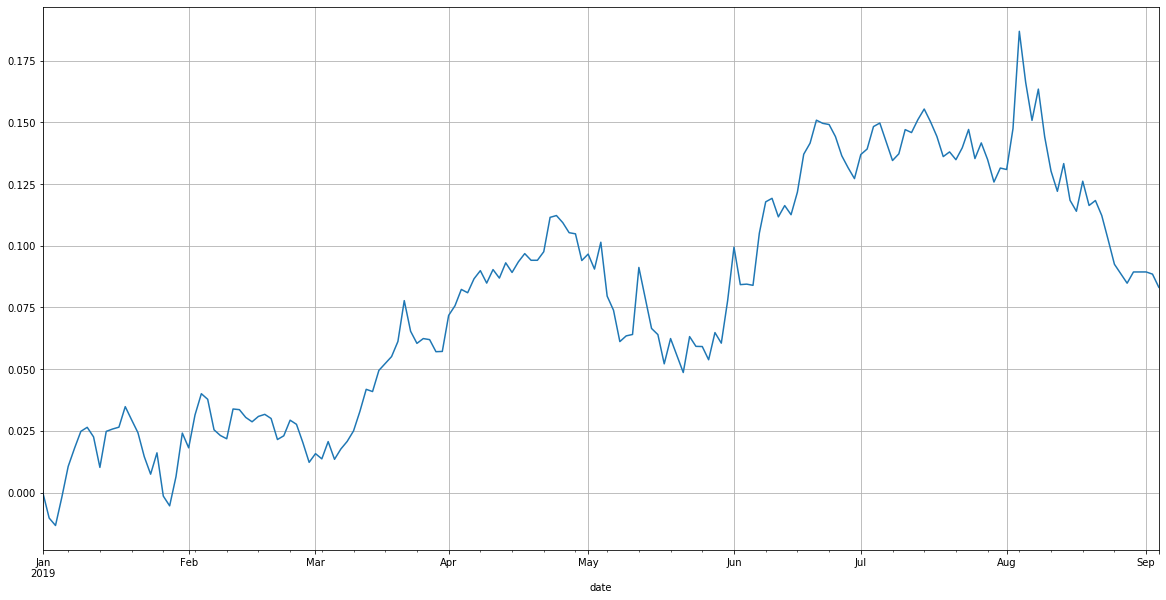

In [16]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

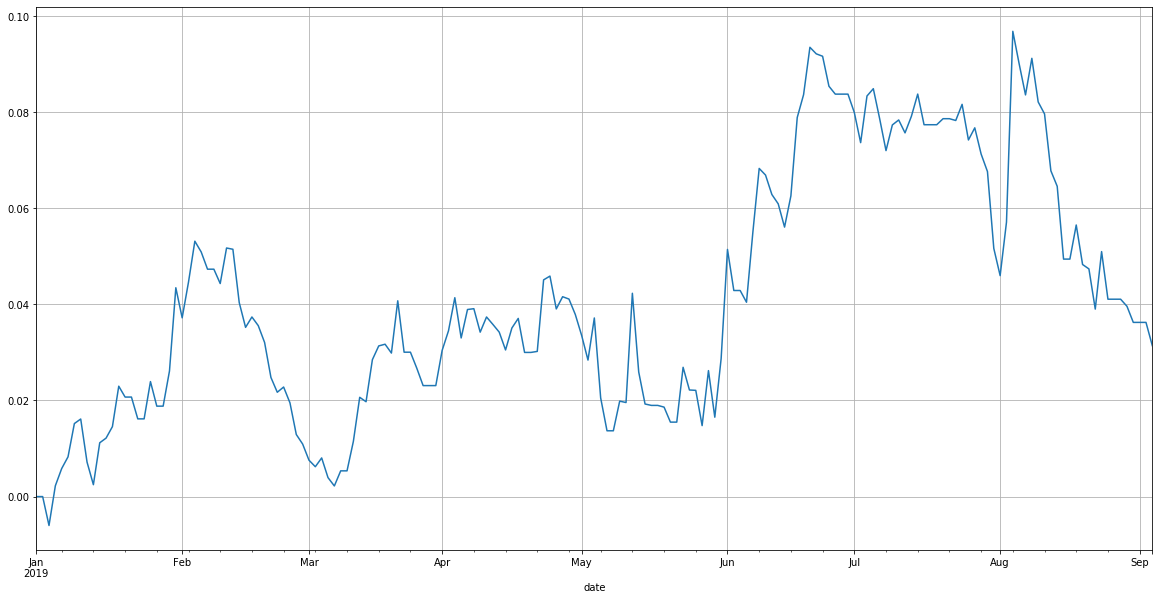

In [17]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);